# Code to pull terminus positions from the manual delineations exported from GEEDiT

_By Jukes Liu. last modified 11-10-2019._

## Set up:

In [1]:
import pandas as pd
import numpy as np
import os
import subprocess
import matplotlib.pyplot as plt
import cv2
import matplotlib.image as mpimg
import matplotlib.pylab as pl
import numpy.ma as ma
import datetime
import math
from PIL import Image
import scipy.misc
import shutil

#geospatial packages
import fiona
import geopandas as gpd
from shapely.geometry import Polygon, Point, LineString
import shapely
#shapely to explore 2D spatial relationships (e.g. intersection of 2 vector files)

os.chdir('/home/jukes/automated-glacier-terminus')
from automated_terminus_functions import to_datetimes, within, distance #import necessary functions 

basepath = '/media/jukes/jukes1/Manual/EarthEngine/'

In [2]:
#Read in glacier velocity data
flowspeed_df= pd.read_csv('/home/jukes/Documents/Sample_glaciers/Glacier_vel_measures_sample10.csv', sep=',', dtype=str)
# flowspeed_df= pd.read_csv('/home/jukes/Documents/Sample_glaciers/Glacier_velocities.csv', sep=',', dtype=str, usecols=[1,2,3])
flowspeed_df = flowspeed_df.set_index('BoxID')

## 1) Reproject manual delineation shapefiles into Greenland Polar Stereo and grab BoxIDs

For different versions of delineations of the same image, pick the most recent one (2) instead of (1) or the original.

In [ ]:
# counter = 0
# taggedimgs = []
# tagged2 = []
# BoxIDs = []

# for file in os.listdir(basepath):
#     if '(' in file and file not in taggedimgs:
#         taggedimgs.append(file.split('(')[0])

# for file in os.listdir(basepath):
#     for img in taggedimgs: 
#         if file.startswith(img) and '(' not in file:
#             #remove the images without parentheses
#             if file in os.listdir(basepath):
#                 os.remove(basepath+file)
#         if file.startswith(img) and '(2)' in file:
#             tagged2.append(file.split('(')[0])
# tagged2 = set(tagged2)

# for file in os.listdir(basepath):
#     for img in tagged2: 
#         if file.startswith(img) and '(1)' in file:
#             os.remove(basepath+file)
#             print(file)

Reproject into Greenland Polar Stereo:

In [42]:
counter = 0
BoxIDs = []

for folder in os.listdir(basepath):
    BoxIDs.append(folder[3:])
    
    for file in os.listdir(basepath+folder):
        if file.endswith('.shp'):
#             #pull BoxID from name of file
#             BoxID = '%03d' % int(file.split('_')[0][3:])

            #reproject the file from lat, long to Greenland Polar Stereo
            linepath = basepath+folder+'/'+file[:-4]
            rp_command = 'ogr2ogr -f "ESRI Shapefile" -t_srs EPSG:3413 -s_srs EPSG:4326 '+linepath+'_PS.shp '+linepath+'.shp'
#             print(rp_command)
            subprocess.call(rp_command, shell=True)

            #keep track of how many shapefiles there are
            counter = counter + 1
        
print(counter)
BoxIDs = list(set(BoxIDs))
print(BoxIDs)

2123
['001', '259', '174', '002', '120']


Split into their own box folders:

In [ ]:
# #make results directory in BoxID folder if it doesn't already exist
# for BoxID in BoxIDs:
#     if os.path.exists(basepath+"Box"+BoxID):
#         print("Already exists.")
#         #OTHERWISE, create the folder and download into it
#     else:
#         os.mkdir(basepath+"Box"+BoxID)
#         print("Folder made for Box"+BoxID)

In [ ]:
# #move em!
# for BoxID in BoxIDs:
#     box = '%01d' % int(BoxID)
#     for file in os.listdir(basepath):
#         if file.startswith('Box'+box) and len(file)>6:
#             shutil.move(basepath+file, basepath+'Box'+BoxID+'/'+file)
#             print(file+' moved')

## 2) Rasterize the shapefiles and subset to the buffer zones

In [ ]:
# for folder in os.listdir(basepath):
#     BoxID = folder[3:]
#     for file in os.listdir(basepath+folder):
# #       print(file)
#         if file.endswith('PS.shp'):
#             linepath = basepath+folder+'/'+file[:-4]
#             rasterize_cmd = 'gdal_rasterize -burn 1.0 -tr 15.0 15.0 -a_nodata 0.0 '+linepath+'.shp '+linepath+'.TIF'
# #             print(rasterize_cmd)
            
#             subprocess.call(rasterize_cmd, shell=True)

In [43]:
for folder in os.listdir(basepath):
    BoxID = folder[3:]
    if BoxID == '259':
        for file in os.listdir(basepath+folder):
    #       print(file)
            if file.endswith('PS.shp'):
                linepath = basepath+folder+'/'+file[:-4]
                buffer_path = "/home/jukes/Documents/Sample_glaciers/Box"+BoxID+"/Buffer"+BoxID+".shp"

                subsetbuffer_cmd = 'gdalwarp -cutline '+buffer_path+' -crop_to_cutline '+linepath+'.TIF'+" "+linepath+'_cut_c1.TIF'
    #             print(subsetbuffer_cmd)
                subprocess.call(subsetbuffer_cmd, shell=True)

## 3) Rotate the rasterized & subset delineations

Convert images to png files

In [5]:
flowspeed_df = flowspeed_df.drop(['004', '033', '235', '277', '531'])

In [ ]:
# #convert all raster delineation files to png
# for index, row in flowspeed_df.iterrows():
# # for BoxID in ['279']:
#     BoxID = index
#     command = 'cd '+basepath+'Box'+BoxID+'/; '+'mogrify -format png *cut_c1.TIF'
#     subprocess.call(command, shell=True)

Make rotated folders and rotate

In [10]:
BoxIDs = list(flowspeed_df.index)
# #make results directory in BoxID folder if it doesn't already exist
# for BoxID in BoxIDs:
#     if os.path.exists(basepath+"Box"+BoxID+'/rotated_c1/'):
#         print("Already exists.")
#         #OTHERWISE, create the folder and download into it
#     else:
#         os.mkdir(basepath+"Box"+BoxID+'/rotated_c1/')
#         print("Folder made for Box"+BoxID)

In [51]:
for folder in os.listdir(basepath):
    BoxID = folder[3:]
    if BoxID == '259':
        for file in os.listdir(basepath+folder):
    #         print(file)
            if file.endswith('PS_cut_c1.png'):
                img  = Image.open(basepath+folder+'/'+file)
                #rotate the image by the flow direction from flowspeed_df
                rotated     = img.rotate(-float(flowspeed_df.loc[BoxID, 'Flow_dir']))
                rotated.save(basepath+folder+'/rotated_c1/R_'+file)
    #             print(file)
    #             print(flowspeed_df.loc['001', 'Flow_dir'])

In [45]:
for folder in os.listdir(basepath):
    BoxID = folder[3:]
    if BoxID == '259':
        for file in os.listdir(basepath+folder+'/rotated_c1/'):
    #         print(file)
            if len(file) > 55:
                os.remove(basepath+folder+'/rotated_c1/'+file)

## 4) Resize all images to minimum image dimensions

Move terminus box rasters to the folder:

In [50]:
for BoxID in BoxIDs:
    if BoxID != '259':
        pathtotbox = '/media/jukes/jukes1/LS8aws/Box'+BoxID+'/rotated_c1/R_Box'+BoxID+'_raster_cut.png'
        shutil.copy(pathtotbox, basepath+'Box'+BoxID+'/rotated_c1/R_Box'+BoxID+'_raster_cut.png')
    else:
        pathtotbox = '/home/jukes/Documents/Sample_glaciers/Box'+BoxID+'/Box'+BoxID+'_raster_cut.png'
        shutil.copy(pathtotbox, basepath+'Box'+BoxID+'/Box'+BoxID+'_raster_PS_cut_c1.png') 

In [3]:
# # import necessary functions from automated-glacier-terminus.py
# os.chdir('/home/jukes/automated-glacier-terminus') #import necessary functions:
# from automated_terminus_functions import resize_pngs

Grab image dimensions from automated images, crop all to the automated dimensions

In [8]:
# for index, row in flowspeed_df.iterrows():
#     BoxID = index
#     print(BoxID)
#     path = '/media/jukes/jukes1/LS8aws/Box'+BoxID+'/rotated_c1/'
#     resize_pngs(path)

In [52]:
for BoxID in BoxIDs:
    if BoxID == '259':
        images = os.listdir('/media/jukes/jukes1/LS8aws/Box'+BoxID+'/rotated_c1/')
        for image in images:
            if image.endswith('.png'):
                imagetest = mpimg.imread('/media/jukes/jukes1/LS8aws/Box'+BoxID+'/rotated_c1/'+image)
                #grab image dimensions
                min_y=imagetest.shape[0]; min_x = imagetest.shape[1]
        print(BoxID, min_x, min_y)

        for image in os.listdir(basepath+'Box'+BoxID+'/rotated_c1/'):
            if image.startswith('R_crop_Box'):
                os.remove(basepath+'Box'+BoxID+'/rotated_c1/'+image)
        for image in os.listdir(basepath+'Box'+BoxID+'/rotated_c1/'):
            if image.endswith('.png'):
                #crop each image if the dimensions are larger than the minimum
                img = mpimg.imread(basepath+'Box'+BoxID+'/rotated_c1/'+image)
                rows = img.shape[0]; columns = img.shape[1]
                #calculate difference, and divide by 2 to get amount of rows to remove by
                diffx_half = (columns - min_x)/2; diffy_half = (rows - min_y)/2 

                if diffx_half > 0 or diffy_half > 0:
                    #if the difference is a half pixel, make sure to remove the full value from the first side only
                    if int(diffx_half) != diffx_half:
                        #remember for image slicing y is number of rows, x is the number of columns
                        img_cropx = img[:, int(diffx_half):-int(diffx_half)-1]
                    #otherwise remove it from both sides:
                    else:
                        img_cropx = img[:, int(diffx_half):-int(diffx_half)]

                    #same for y
                    if int(diffy_half) != diffy_half:   
                        img_cropy = img_cropx[int(diffy_half):-int(diffy_half)-1, :]
                    #otherwise remove it from both sides:
                    else:
                        img_cropy = img_cropx[int(diffy_half):-int(diffy_half), :]

                    #save over rotated images with new cropped dimensions:
                    resized = np.ascontiguousarray(img_cropy)
                    plt.imsave(basepath+"Box"+BoxID+'/rotated_c1/'+image[:-4]+'.png', resized, cmap='gray')

                #add 0s if image dimensions are smaller than the min! (001)
                elif diffx_half < 0 or diffy_half < 0:
                    #columns (x):
                    diffx_half = abs(diffx_half); diffy_half = abs(diffy_half)
                    #if the difference is a half pixel, add the full one to end
                    if int(diffx_half) != diffx_half and int(diffx_half) != 0:
                        img_addx1 = np.column_stack((np.zeros((rows, int(diffx_half))), img))
                        img_addx2 = np.column_stack((img_addx1, np.zeros((rows, int(diffx_half)+1))))
                    #if it's a whole pixel, add to cols to beginning and end
                    else:
                        img_addx1 = np.column_stack((np.zeros((rows, int(diffx_half))), img))
                        img_addx2 = np.column_stack((img_addx1, np.zeros((rows, int(diffx_half)))))
                    #rows(y):
                    if int(diffy_half) != diffy_half:
                        img_addy1 = np.vstack((np.zeros((int(diffy_half), img_addx2.shape[1])), img_addx2))
                        img_addy2 = np.vstack((img_addy1, np.zeros((int(diffy_half)+1, img_addx2.shape[1]))))
                    else:
                        img_addy1 = np.vstack((np.zeros((int(diffy_half), img_addx2.shape[1])), img_addx2))
                        img_addy2 = np.vstack((img_addy1, np.zeros((int(diffy_half), img_addx2.shape[1]))))

                    #save over rotated images with new cropped dimensions:
                    resized = np.ascontiguousarray(img_addy2)
                    plt.imsave(basepath+"Box"+BoxID+'/rotated_c1/'+image[:-4]+'.png', resized, cmap='gray')

259 553 594


## 5) Read in rasterized delineations and grab pixel coordinates

In [78]:
IDs = []; line_xs = []; line_ys = []; dates = []

for BoxID in BoxIDs:
    for file in os.listdir(basepath+'Box'+BoxID+'/rotated_c1/'):
        if file.startswith('R') and file.endswith('cut_c1.png'):
            #pull date from name of file
            date = file.split('_')[5][:10]

            linepath = basepath+'Box'+BoxID+'/rotated_c1/'+file; line = cv2.imread(linepath)
#             print(line.shape)
            
            if len(line.shape) > 2:
#                 print(line)
                y, x, rgb = np.where(line > 0)

                line_x = []; line_y = []
                for i in range(0, len(y)):
                    x0 = x[i]; y0 = y[i]; rgb0 = rgb[i]

                    if rgb0 == 0:
#                         print(x0, y0, rgb0)
                        line_x.append(x0); line_y.append(y0)

                IDs.append(BoxID); dates.append(date); line_xs.append(line_x); line_ys.append(line_y)

manual_df = pd.DataFrame(list(zip(IDs, dates, line_xs, line_ys)),
              columns=['BoxID','datetimes', 'Line_x', "Line_y"])
manual_df = manual_df.sort_values(by=['BoxID', 'datetimes'])
manual_df

,BoxID,datetimes,Line_x,Line_y
10,001,2013-05-05,"[123, 124, 121, 122, 121, 120, 120, 122, 122, ...","[123, 123, 124, 124, 125, 126, 127, 127, 128, ..."
61,001,2013-05-14,"[121, 121, 122, 122, 122, 123, 124, 124, 125, ...","[125, 126, 127, 128, 129, 130, 130, 131, 132, ..."
72,001,2013-05-29,"[120, 120, 122, 122, 123, 124, 124, 126, 126, ...","[126, 127, 127, 128, 129, 130, 131, 132, 133, ..."
136,001,2013-08-23,"[121, 121, 119, 120, 117, 118, 118, 118, 119, ...","[122, 123, 124, 124, 126, 126, 127, 128, 129, ..."
110,001,2013-08-27,"[119, 119, 118, 118, 118, 118, 119, 121, 121, ...","[124, 125, 126, 127, 128, 129, 129, 130, 131, ..."
...,...,...,...,...
202,259,2016-10-13,"[157, 157, 157, 157, 157, 157, 157, 157, 157, ...","[384, 386, 387, 388, 389, 390, 392, 394, 395, ..."
158,259,2016-10-20,"[156, 156, 156, 156, 157, 157, 157, 157, 158, ...","[388, 389, 390, 391, 392, 393, 394, 395, 396, ..."
205,259,2016-10-29,"[153, 154, 153, 154, 154, 154, 154, 154, 154, ...","[392, 393, 394, 395, 397, 399, 400, 401, 402, ..."
176,259,2016-11-07,"[153, 153, 153, 153, 153, 153, 153, 153, 154, ...","[394, 396, 398, 399, 400, 401, 402, 404, 405, ..."


In [79]:
box_df = manual_df[manual_df['BoxID']=='259']

In [93]:
centerline_df

,lmid50_x,lmid50_y,rmid50_x,m50,b50,lmid25_x,lmid25_y,rmid25_x,m25,b25,lmid75_x,lmid75_y,rmid75_x,m75,b75
BoxID,,,,,,,,,,,,,,,
120,68.5,99.0,139.0,0.20567375886524822,84.91134751773049,71.75,84.0,142.0,0.20284697508896798,69.24290780141844,65.25,114.0,136.0,0.20848056537102475,100.57978723404256
174,148.5,222.5,285.5,-0.1386861313868613,243.09489051094891,144.75,194.75,281.25,-0.14285714285714285,214.82481751824818,152.25,250.25,289.75,-0.13454545454545455,271.3649635036496
259,141.5,390.5,410.5,-0.6933085501858736,488.60315985130114,129.25,372.75,398.25,-0.6923791821561338,462.36013011152414,153.75,408.25,422.75,-0.6942379182156134,514.8461895910781
002,406.5,524.5,689.0,-0.08672566371681416,559.7539823008849,403.25,486.25,686.0,-0.08576480990274093,521.2221238938054,409.75,562.75,692.0,-0.08768821966341896,598.2858407079646
001,101.0,142.0,174.5,0.08163265306122448,133.75510204081633,102.0,132.5,174.75,0.07560137457044673,124.1734693877551,100.0,151.5,174.25,0.08754208754208755,143.33673469387756


In [99]:
centerline_df.at['259','lmid50_y']

'390.5'

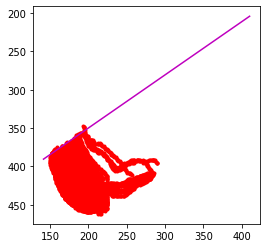

In [113]:
# box = mpimg.imread(basepath+'Box259/rotated_c1/R_Box259_raster_PS_cut.pgm')
# yindices, xindices = np.where(box > 0) #keep the pixels of where thevalue is nonzero (where the box exists)
# plt.plot(xindices, yindices, 'yo')

 #grab slope and intercepts from the dataframe
BoxID = '259'
c_slope = float(centerline_df.loc[BoxID]['m50'])
c_intercept = float(centerline_df.loc[BoxID]['b50'])
m25 = float(centerline_df.loc[BoxID]['m25']); b25 = float(centerline_df.loc[BoxID]['b25'])
m75 = float(centerline_df.loc[BoxID]['m75']); b75 = float(centerline_df.loc[BoxID]['b75'])

#grab x-values from height of terminus box
ymid = float(centerline_df.loc[BoxID]['lmid50_y']); xmid = float(centerline_df.loc[BoxID]['lmid50_x'])
xmax = float(centerline_df.loc[BoxID]['rmid50_x'])
ymid25 = float(centerline_df.loc[BoxID]['lmid25_y']); xmid25 = float(centerline_df.loc[BoxID]['lmid25_x'])
xmax25 = float(centerline_df.loc[BoxID]['rmid25_x'])
ymid75 = float(centerline_df.loc[BoxID]['lmid75_y']); xmid75 = float(centerline_df.loc[BoxID]['lmid75_x'])
xmax75 = float(centerline_df.loc[BoxID]['rmid75_x'])
            
#calculate centerlines:
cx50 = np.linspace(xmid, xmax, int(xmax-xmid)*10); cy50 = c_slope*cx50 + c_intercept
cx25 = np.linspace(xmid25, xmax25, int(xmax25-xmid25)*10); cy25 = m25*cx25 + b25
cx75 = np.linspace(xmid75, xmax75, int(xmax75-xmid75)*10); cy75 = m75*cx75 + b75

            
for idx, row in box_df.iterrows():
    line_xs = row['Line_x']; line_ys = row['Line_y']
    plt.plot(line_xs, line_ys, 'r.')
    
plt.plot(cx50, cy50, 'm-')
# plt.scatter(float(centerline_df.at['259','lmid50_x']), float(centerline_df.at['259','lmid50_y']), c='m');
# plt.scatter(float(centerline_df.at['259','lmid25_x']), float(centerline_df.at['259','lmid25_y']), c='r'); 
# plt.scatter(float(centerline_df.at['259','lmid75_x']), float(centerline_df.at['259','lmid75_y']), c='b'); 

plt.gca().invert_yaxis(); plt.axis('scaled'); plt.show()

## Manual delineations gif Box001

In [ ]:
# #Turn datetimes from datetime_df into DateTime objects
# to_datetimes(manual_df)

In [ ]:
# manual_df.to_csv(path_or_buf = basepath+"Manual_imgdates.csv", sep=',')

In [ ]:
# #PLOT THE LANDSAT IMAGE and TERMINUS BOX
# BoxID = '001'
# box_df = manual_df[manual_df.BoxID == BoxID].copy()
# # box_df = box_df[box_df.Date > np.datetime64('2013-01-01')].copy()

# #Read in the non_rotated subset image:
# # image = mpimg.imread('/media/jukes/jukes1/LS8aws/Box'+BoxID+'/rotated/crop_manual/R_LC80310052014178LGN00_B8_PS_Buffer'+BoxID+'.png')
# tbox = mpimg.imread("/media/jukes/jukes1/LS8aws/Box"+BoxID+"/rotated/crop_manual/Box"+BoxID+"_raster_cut.png")

# plt.figure(figsize=(20,10))
# plt.axis("off")
# imgplt_trim = plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
# boxplt = plt.imshow(tbox, alpha=0.1)

# counter = 0
# for idx, row in box_df.iterrows():
#     if idx % 7 == 0:
#         counter = counter + 1
        
# colors = pl.cm.viridis(np.linspace(0,1,counter))

# col_count = 0
# for idx, row in box_df.iterrows():
#     if idx % 7 == 0:
#         #     BoxID = idx
#         line_x = row['Line_x']
#         line_y = row['Line_y']

#         plt.plot(line_x, line_y, color=colors[col_count], linewidth=0.5)
#         col_count = col_count+1
        
# #grab x-values from height of terminus box
# c_slope = float(centerline_df.loc[BoxID]['cline_slope'])
# c_intercept = float(centerline_df.loc[BoxID]['cline_intercept'])
# xmin = float(centerline_df.loc[BoxID]['midpoint_x'])
# xmax = np.max(np.array(list(set(np.nonzero(tbox)[1]))))

# c_x = np.linspace(xmin, xmax, int(xmax-xmin)*2)
# c_y = c_slope*c_x + c_intercept
# plt.plot(c_x, c_y, color='gray')
# plt.plot(c_x[0], c_y[0], 'co')

# plt.show()


## 5) Calculate interesections with centerline and terminus position

Read in 3 centerlines (25, 50, 75)

In [53]:
# pathrows_df = pd.read_csv(basepath+'LS_pathrows_multiple.csv', sep=',', usecols =[0,1,2], dtype=str)
centerline_df = pd.read_csv('/home/jukes/Documents/Sample_glaciers/Boxes_coords_pathrows_sample5.csv', sep=',',dtype=str)
centerline_df = centerline_df.set_index('BoxID')
centerline_df

,lmid50_x,lmid50_y,rmid50_x,m50,b50,lmid25_x,lmid25_y,rmid25_x,m25,b25,lmid75_x,lmid75_y,rmid75_x,m75,b75
BoxID,,,,,,,,,,,,,,,
120,68.5,99.0,139.0,0.20567375886524822,84.91134751773049,71.75,84.0,142.0,0.20284697508896798,69.24290780141844,65.25,114.0,136.0,0.20848056537102475,100.57978723404256
174,148.5,222.5,285.5,-0.1386861313868613,243.09489051094891,144.75,194.75,281.25,-0.14285714285714285,214.82481751824818,152.25,250.25,289.75,-0.13454545454545455,271.3649635036496
259,141.5,390.5,410.5,-0.6933085501858736,488.60315985130114,129.25,372.75,398.25,-0.6923791821561338,462.36013011152414,153.75,408.25,422.75,-0.6942379182156134,514.8461895910781
002,406.5,524.5,689.0,-0.08672566371681416,559.7539823008849,403.25,486.25,686.0,-0.08576480990274093,521.2221238938054,409.75,562.75,692.0,-0.08768821966341896,598.2858407079646
001,101.0,142.0,174.5,0.08163265306122448,133.75510204081633,102.0,132.5,174.75,0.07560137457044673,124.1734693877551,100.0,151.5,174.25,0.08754208754208755,143.33673469387756


In [117]:
intersection_x = []; intersection_y = []
ix_25 = []; iy_25 = []; ix_75 = []; iy_75 = []
term_pos50 = []; tpos25 = []; tpos75 = []

prev_BoxID = 'anything'

for idx, row in manual_df.iterrows():
#     print(str(row['datetimes'])[:10])
#     if row['BoxID'] == '259':
        line_x = row['Line_x']; line_y = row['Line_y']
        
        if row['BoxID'] != prev_BoxID:
            #don't duplicate efforts in calculating a new centerline
            BoxID = row['BoxID']

            #grab slope and intercepts from the dataframe
            c_slope = float(centerline_df.loc[BoxID]['m50'])
            c_intercept = float(centerline_df.loc[BoxID]['b50'])
            m25 = float(centerline_df.loc[BoxID]['m25']); b25 = float(centerline_df.loc[BoxID]['b25'])
            m75 = float(centerline_df.loc[BoxID]['m75']); b75 = float(centerline_df.loc[BoxID]['b75'])

            #grab x-values from height of terminus box
            ymid = float(centerline_df.loc[BoxID]['lmid50_y']); xmid = float(centerline_df.loc[BoxID]['lmid50_x'])
            xmax = float(centerline_df.loc[BoxID]['rmid50_x'])
            ymid25 = float(centerline_df.loc[BoxID]['lmid25_y']); xmid25 = float(centerline_df.loc[BoxID]['lmid25_x'])
            xmax25 = float(centerline_df.loc[BoxID]['rmid25_x'])
            ymid75 = float(centerline_df.loc[BoxID]['lmid75_y']); xmid75 = float(centerline_df.loc[BoxID]['lmid75_x'])
            xmax75 = float(centerline_df.loc[BoxID]['rmid75_x'])
            
            #calculate centerlines:
            cx50 = np.linspace(xmid, xmax, int(xmax-xmid)*10); cy50 = c_slope*cx50 + c_intercept
            cx25 = np.linspace(xmid25, xmax25, int(xmax25-xmid25)*10); cy25 = m25*cx25 + b25
            cx75 = np.linspace(xmid75, xmax75, int(xmax75-xmid75)*10); cy75 = m75*cx75 + b75

        #FIND Intersections   
        intersect_xs = []; intersect_ys = []; intersect_xs25 = []; intersect_ys25 = []; intersect_xs75 = []; intersect_ys75 = []

        #loop through all the x,y values for the delineation:
        for j in range(0, len(line_x)):
            lx = line_x[j]; ly = line_y[j]
            interval = 1.0
            #find intersections with each centerline:
            for i in range(0, len(cx50)):
                if within(lx, cx50[i], interval) and within (ly, cy50[i], interval):
                    intersect_xs.append(lx); intersect_ys.append(ly)
            for k in range(0, len(cx25)):
                if within(lx, cx25[k], interval) and within (ly, cy25[k], interval):
                    intersect_xs25.append(lx); intersect_ys25.append(ly)
            for l in range(0, len(cx75)):
                if within(lx, cx75[l], interval) and within (ly, cy75[l], interval):
                    intersect_xs75.append(lx); intersect_ys75.append(ly)
#         print(len(intersect_xs75), len(intersect_ys75))

        #if there are intersections, calculate the terminus positions:
        if len(intersect_xs) != 0 or len(intersect_ys) != 0:
                #this was too slow, just use min
#             intersect_x = np.min(intersect_xs)
#             intersect_y = intersect_ys[intersect_xs.index(intersect_x)]
            intersect_x = intersect_xs[0]; intersect_y = intersect_ys[0]
#             print(BoxID, row['datetimes'], intersect_x, intersect_y)
            intersection_x.append(intersect_x); intersection_y.append(intersect_y)
            #calculate terminus position using distance formula
            term_position = distance(xmid, ymid, intersect_x, intersect_y)
#             term_position = intersect_x-xmid
            term_pos50.append(term_position*15.0)
        #otherwise, append nans
        else:
            intersection_x.append(np.nan); intersection_y.append(np.nan); term_pos50.append(np.nan)  
            
        if len(intersect_xs25) != 0 or len(intersect_ys25) != 0:
            ix25 = intersect_xs25[0]; iy25 = intersect_ys25[0]
#             print(BoxID, row['datetimes'], ix25, iy25, "L25")
            ix_25.append(ix25); iy_25.append(iy25)
            #calculate terminus position using distance formula
            term_position25 = distance(xmid25, ymid25, ix25, iy25)
#             term_position25 = ix25-xmid25
            tpos25.append(term_position25*15.0)
        #otherwise, append nans
        else:
            ix_25.append(np.nan); iy_25.append(np.nan); tpos25.append(np.nan)  
        
        if len(intersect_xs75) != 0 or len(intersect_ys75) != 0:
            ix75 = intersect_xs75[0] ;iy75 = intersect_ys75[0]
#             print(BoxID, row['datetimes'], ix75, iy75, "L75")
            ix_75.append(ix75); iy_75.append(iy75)
            #calculate terminus position using distance formula
            term_position75 = distance(xmid75, ymid75, ix75, iy75)
#             term_position75 = ix75-xmid75
            tpos75.append(term_position75*15.0)
        #otherwise, append nans
        else:
#             print(BoxID, row['datetimes'], "nan, L75")
            ix_75.append(np.nan); iy_75.append(np.nan); tpos75.append(np.nan)
            
        prev_BoxID = BoxID
        
manual_df['intersect_x'] = intersection_x; manual_df['intersect_y'] = intersection_y
manual_df['tpos50'] = term_pos50; manual_df['tpos25'] = tpos25; manual_df['tpos75'] = tpos75
# manual_df = manual_df.dropna()
manual_df

,BoxID,datetimes,Line_x,Line_y,intersect_x,intersect_y,tpos50,tpos25,tpos75
10,001,2013-05-05,"[123, 124, 121, 122, 121, 120, 120, 122, 122, ...","[123, 123, 124, 124, 125, 126, 127, 127, 128, ...",127.0,144.0,391.152144,360.078117,NaN
61,001,2013-05-14,"[121, 121, 122, 122, 122, 123, 124, 124, 125, ...","[125, 126, 127, 128, 129, 130, 130, 131, 132, ...",128.0,144.0,406.109591,345.081512,NaN
72,001,2013-05-29,"[120, 120, 122, 122, 123, 124, 124, 126, 126, ...","[126, 127, 127, 128, 129, 130, 131, 132, 133, ...",129.0,144.0,421.070065,360.078117,436.613387
136,001,2013-08-23,"[121, 121, 119, 120, 117, 118, 118, 118, 119, ...","[122, 123, 124, 124, 126, 126, 127, 128, 129, ...",125.0,144.0,361.247837,315.089273,406.732406
110,001,2013-08-27,"[119, 119, 118, 118, 118, 118, 119, 121, 121, ...","[124, 125, 126, 127, 128, 129, 129, 130, 131, ...",126.0,143.0,375.299880,315.089273,406.732406
...,...,...,...,...,...,...,...,...,...
202,259,2016-10-13,"[157, 157, 157, 157, 157, 157, 157, 157, 157, ...","[384, 386, 387, 388, 389, 390, 392, 394, 395, ...",NaN,NaN,NaN,NaN,90.156115
158,259,2016-10-20,"[156, 156, 156, 156, 157, 157, 157, 157, 158, ...","[388, 389, 390, 391, 392, 393, 394, 395, 396, ...",NaN,NaN,NaN,NaN,111.369318
205,259,2016-10-29,"[153, 154, 153, 154, 154, 154, 154, 154, 154, ...","[392, 393, 394, 395, 397, 399, 400, 401, 402, ...",NaN,NaN,NaN,NaN,38.608613
176,259,2016-11-07,"[153, 153, 153, 153, 153, 153, 153, 153, 154, ...","[394, 396, 398, 399, 400, 401, 402, 404, 405, ...",NaN,NaN,NaN,NaN,38.608613


In [119]:
manual_df[manual_df['BoxID'] == '259']

,BoxID,datetimes,Line_x,Line_y,intersect_x,intersect_y,tpos50,tpos25,tpos75
214,259,2013-08-18,"[190, 191, 192, 193, 194, 195, 195, 196, 196, ...","[356, 356, 357, 357, 358, 358, 359, 360, 362, ...",190.0,356.0,892.783568,NaN,875.365995
206,259,2013-08-25,"[193, 194, 194, 195, 195, 195, 196, 195, 196, ...","[347, 348, 349, 349, 350, 352, 353, 354, 355, ...",195.0,352.0,988.692318,NaN,929.410095
183,259,2013-09-03,"[181, 181, 181, 180, 180, 179, 179, 179, 179, ...","[363, 364, 365, 366, 368, 369, 370, 371, 372, ...",181.0,363.0,721.950483,NaN,530.250530
207,259,2013-09-03,"[177, 177, 178, 177, 177, 178, 178, 178, 178, ...","[370, 371, 371, 372, 373, 373, 374, 375, 376, ...",NaN,NaN,NaN,NaN,530.250530
165,259,2013-09-26,"[186, 185, 186, 186, 187, 187, 188, 188, 189, ...","[360, 362, 362, 363, 364, 365, 366, 367, 368, ...",186.0,360.0,809.235751,NaN,650.406123
...,...,...,...,...,...,...,...,...,...
202,259,2016-10-13,"[157, 157, 157, 157, 157, 157, 157, 157, 157, ...","[384, 386, 387, 388, 389, 390, 392, 394, 395, ...",NaN,NaN,NaN,NaN,90.156115
158,259,2016-10-20,"[156, 156, 156, 156, 157, 157, 157, 157, 158, ...","[388, 389, 390, 391, 392, 393, 394, 395, 396, ...",NaN,NaN,NaN,NaN,111.369318
205,259,2016-10-29,"[153, 154, 153, 154, 154, 154, 154, 154, 154, ...","[392, 393, 394, 395, 397, 399, 400, 401, 402, ...",NaN,NaN,NaN,NaN,38.608613
176,259,2016-11-07,"[153, 153, 153, 153, 153, 153, 153, 153, 154, ...","[394, 396, 398, 399, 400, 401, 402, 404, 405, ...",NaN,NaN,NaN,NaN,38.608613


In [120]:
manual_df.to_csv(path_or_buf='/media/jukes/jukes1/Manual/manual_tpos_c1.csv', sep=',')

## Analyze interanalyst variability:

In [20]:
#Read in duplicate delineations
duplicate_df = pd.read_csv('/media/jukes/jukes1/Manual/LS8_manual_auto_Jan2020_2analysts.csv', usecols=[0,1,2],
                           sep=',')
duplicate_df = duplicate_df.set_index('BoxID')
duplicate_df.head(10)

,Date,Condition
BoxID,,
1,2016-04-18,Sea ice
1,2017-04-03,Sea ice
1,2016-07-07,Clear
1,2016-08-24,Cloudy
1,2016-03-01,Dim
1,2014-09-18,Dim
1,2015-03-31,Cloudy
1,2014-06-09,Sea ice
1,2015-03-10,Clear


In [66]:
df_2

,BoxID,datetimes,Line_x,Line_y,intersect_x,intersect_y,tpos50,tpos25,tpos75


In [21]:
differences = []; diffs25 = []; diffs75 = []

for idx, row in duplicate_df.iterrows():
    #grab the BoxID and date of duplicate delineation
    BoxID = '%03d' % int(idx)
    date = str(row['Date'])
#     print(len(date))
    if True == True:
#     if date == '2014-08-14':
        df_1 = manual_df[manual_df['BoxID']==BoxID].copy()
    #     print(len(df_1))
        df_2 = df_1[df_1['datetimes']==date].copy()
#         print(df_2)

        #grab the terminus position values from duplicates in manual_df
        if len(list(df_2['tpos50'])) > 1:
            x50_1, x50_2 = list(df_2['tpos50'])
            diff50 = abs(x50_2-x50_1) # CHANGE THESE TO DISTANCE FORMULA
            differences.append(diff50)
        else:
            differences.append(np.NaN)
        if len(list(df_2['tpos25'])) > 1:
            x25_1, x25_2 = list(df_2['tpos25'])
            diff25 = abs(x25_2-x25_1)
            diffs25.append(diff25)
        else:
            diffs25.append(np.NaN)
        if len(list(df_2['tpos75'])) > 1:
            x75_1, x75_2 = list(df_2['tpos75'])
            diff75 = abs(x75_2-x75_1)
            diffs75.append(diff75)
        else:
            diffs75.append(np.NaN)

duplicate_df['diff50'] = differences
duplicate_df['diff25'] = diffs25
duplicate_df['diff75'] = diffs75

In [22]:
duplicate_df

,Date,Condition,diff50,diff25,diff75
BoxID,,,,,
1,2016-04-18,Sea ice,0.0,15.0,30.0
1,2017-04-03,Sea ice,0.0,30.0,15.0
1,2016-07-07,Clear,0.0,15.0,0.0
1,2016-08-24,Cloudy,0.0,30.0,0.0
1,2016-03-01,Dim,60.0,75.0,45.0
1,2014-09-18,Dim,0.0,30.0,15.0
1,2015-03-31,Cloudy,15.0,0.0,30.0
1,2014-06-09,Sea ice,0.0,0.0,15.0
1,2015-03-10,Clear,0.0,30.0,30.0


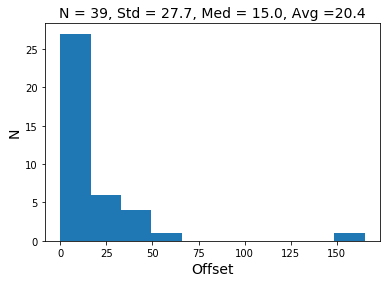

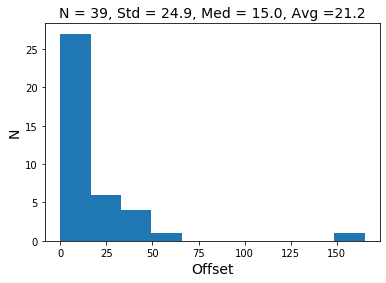

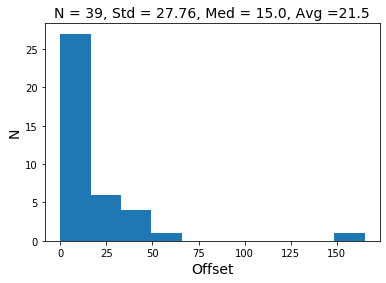

In [26]:
flowlines = ['diff50', 'diff25', 'diff75']

# comparisons50 = list(duplicate_df['diff50'])
# comparisons25 = list(duplicate_df['diff25'])
# comparisons75 = list(duplicate_df['diff75'])

for flowline in flowlines:
    comparison = list(duplicate_df[flowline])
#     cleanedList = [x for x in comparison if str(x) != 'nan']
    
    #std and median:
    std = round(np.nanstd(comparison), 2)
    med = round(np.nanmedian(comparison), 1)
    avg = round(np.nanmean(comparison), 1)
    
    plt.hist(cleanedList, bins=10); plt.ylabel('N',fontsize=14); plt.xlabel('Offset', fontsize=14)
    plt.title('N = '+str(len(cleanedList))+', Std = '+str(std)+', Med = '+str(med)+', Avg ='+str(avg), fontsize=14)
    plt.savefig("/media/jukes/jukes1/Manual/Interanalyst_hist_"+flowline+".png", dpi=500)
    plt.show()

In [25]:
np.average([20.4, 21.2, 21.5])

21.03333333333333

In [27]:
np.average([27.7, 24.9, 27.76])

26.786666666666665

### Result: inter-analyst variability

- Avg standard deviation = 26.8 meters or 1.8 pixels
- Average difference = __~21 meters__ or __1.3 pixels__

## 6) Plot manual terminus position time series

In [126]:
# Turn datetimes from datetime_df into DateTime objects
to_datetimes(manual_df)

,BoxID,datetimes,Line_x,Line_y,intersect_x,intersect_y,tpos50,tpos25,tpos75
10,001,2013-05-05,"[123, 124, 121, 122, 121, 120, 120, 122, 122, ...","[123, 123, 124, 124, 125, 126, 127, 127, 128, ...",127.0,144.0,391.152144,360.078117,NaN
61,001,2013-05-14,"[121, 121, 122, 122, 122, 123, 124, 124, 125, ...","[125, 126, 127, 128, 129, 130, 130, 131, 132, ...",128.0,144.0,406.109591,345.081512,NaN
72,001,2013-05-29,"[120, 120, 122, 122, 123, 124, 124, 126, 126, ...","[126, 127, 127, 128, 129, 130, 131, 132, 133, ...",129.0,144.0,421.070065,360.078117,436.613387
136,001,2013-08-23,"[121, 121, 119, 120, 117, 118, 118, 118, 119, ...","[122, 123, 124, 124, 126, 126, 127, 128, 129, ...",125.0,144.0,361.247837,315.089273,406.732406
110,001,2013-08-27,"[119, 119, 118, 118, 118, 118, 119, 121, 121, ...","[124, 125, 126, 127, 128, 129, 129, 130, 131, ...",126.0,143.0,375.299880,315.089273,406.732406
...,...,...,...,...,...,...,...,...,...
202,259,2016-10-13,"[157, 157, 157, 157, 157, 157, 157, 157, 157, ...","[384, 386, 387, 388, 389, 390, 392, 394, 395, ...",NaN,NaN,NaN,NaN,90.156115
158,259,2016-10-20,"[156, 156, 156, 156, 157, 157, 157, 157, 158, ...","[388, 389, 390, 391, 392, 393, 394, 395, 396, ...",NaN,NaN,NaN,NaN,111.369318
205,259,2016-10-29,"[153, 154, 153, 154, 154, 154, 154, 154, 154, ...","[392, 393, 394, 395, 397, 399, 400, 401, 402, ...",NaN,NaN,NaN,NaN,38.608613
176,259,2016-11-07,"[153, 153, 153, 153, 153, 153, 153, 153, 154, ...","[394, 396, 398, 399, 400, 401, 402, 404, 405, ...",NaN,NaN,NaN,NaN,38.608613


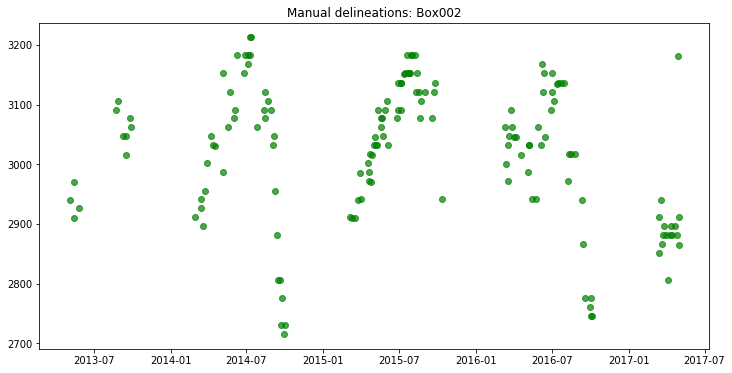

In [128]:
BOI = '002'

df = manual_df[manual_df['BoxID']==BOI].copy()
fig, ax1 = plt.subplots(figsize=(12,6))
ax1.plot(df['datetimes'], df['tpos75'], 'go', markersize='6', alpha=0.7)
plt.title('Manual delineations: Box'+BOI)
plt.show()

## 7) Plot automated vs. manual time series and analyze difference

In [ ]:
#Read in automated df
auto_df = pd.read_csv('/home/jukes/Documents/Sample_glaciers/Tpos_timeseries_Box'+BOI+'_filtered.csv', sep=',')

#Turn datetimes from datetime_df into DateTime objects
to_datetimes(auto_df)

In [ ]:
#grab max and min dates from automated time series:
maxdate = np.max(list(auto_df['datetimes']))
mindate = np.min(list(auto_df['datetimes']))

#grab only manual delineations between those dates
df_2013 = df[df['datetimes'] > mindate].copy()
ls8_df = df_2013[df_2013['datetimes'] < maxdate].copy()

In [ ]:
# # #drop nans
# # ls8_df = ls8_df.dropna()
# # auto_df = auto_df.dropna()

# # # #grab max terminus position across both
# max_tpos_man = np.max(list(ls8_df['tpos50']))#+(2*15.0)
# max_tpos_auto = np.max(list(auto_df['tpos']))
# # max_Y = np.max([max_tpos_man, max_tpos_auto])
# max_Y = max_tpos_man
# # # max_tpos_man = 0
# # # max_tpos_auto = 0
# print(max_tpos_man, max_tpos_auto)
# print(max_Y)

In [ ]:
fig, ax1 = plt.subplots(figsize=(11,6))
#MANUAL
# ax1.plot(ls8_df['datetimes'], np.array(ls8_df['term_position']) - max_tpos_man, 'go', markersize='5', alpha=0.6)
ax1.plot(ls8_df['datetimes'],np.array(ls8_df['tpos50']), 'go', markersize='6', alpha=0.6)
ax1.set_ylabel('Terminus position (m)', color='k', fontsize=16)

#AUTOMATED
offset_px = -7

# ax1.plot(auto_df['datetimes'], np.array(auto_df['tpos'])- max_Y, 'mx', markersize='10', alpha=1)
ax1.plot(auto_df['datetimes'], np.array(auto_df['tpos'])+offset_px*15, 'mx', markersize='8', alpha=1)
# ax2.set_ylabel('Auto terminus position (m)', color = 'k', fontsize=12)
# ax2.get_yaxis().set_visible(False) 

#GENERAL PLOT PARAMETERS
# ax1.set_title("Box"+BOI, fontsize=16)
ax1.set_xlabel('Date', fontsize=16)
ax1.set_ylim(2500, 3400)
ax1.tick_params(axis='both', which='major', labelsize=14)
# fig.legend(['Manual', 'Automated'], bbox_to_anchor=(0.6,0.2), bbox_transform=ax1.transAxes, fontsize=14)
fig.legend(['Manual', 'Automated'], fontsize=14)

#SAVE FIGURE
# plt.title("Box"+BOI)
# plt.grid()
plt.savefig("/media/jukes/jukes1/Manual/Manual_vs_automated_Box"+BOI+".png", dpi=500)
plt.show()

In [ ]:
comparison_df = pd.merge(auto_df.drop(['BoxID', 'changerate','Order'], axis=1), ls8_df.drop(['Line_x', 'Line_y', 'BoxID'], axis=1), how='inner', on='datetimes')
comparison_df = comparison_df.dropna()

In [ ]:
comparison_df

In [ ]:
# #recalculate terminus position for either side
# comparison_df['term_position_x'] = np.array(comparison_df['term_position_x']) - max_tpos_auto
# comparison_df['term_position_y'] = np.array(comparison_df['term_position_y']) - max_tpos_man

In [ ]:
comparison_df['auto_man_diff'] = np.array(comparison_df['tpos50']) - np.array(comparison_df['tpos']-350)
# comparison_df['auto_man_diff'] = np.array(comparison_df['term_position'])-350 - np.array(comparison_df['tpos50'])

In [ ]:
differences = np.array(comparison_df.auto_man_diff)
print("Automated vs. manual delineations")
print(len(comparison_df))
print("Max difference: "+str(np.max(abs(differences)))+' meters')
print("Average difference: "+str(np.average(abs(differences)))+' meters')
print("Median difference: "+str(np.median(abs(differences)))+' meters')